In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mpldts
import calendar
import csv

In [2]:
stn = '154' #067
dataset = 'realtime' # Enter 'archive' or 'realtime'
deploy = '17' # If archive dataset, set deployment number from .nc file

start_date = '10/29/2024 09:00' # MM/DD/YYYY HH:MM
duration  = 30 # Set length of timeseries (minutes)

qc_level = 2 # Filter data with qc flags above this number

In [3]:
# Archive
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_d' + deploy + '.nc'
# Realtime
if dataset == 'realtime':
    data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/' + stn + 'p1_xy.nc'


nc = netCDF4.Dataset(data_url)
# Turn off auto masking
nc.set_auto_mask(False)
nc

<class 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    naming_authority: edu.ucsd.cdip
    keywords_vocabulary: Global Change Master Directory (GCMD) Earth Science Keywords
    date_created: 2025-02-17T19:32:27Z
    date_issued: 2025-02-17T19:32:27Z
    date_modified: 2025-02-17T19:32:27Z
    creator_name: Coastal Data Information Program, SIO/UCSD
    creator_url: http://cdip.ucsd.edu
    creator_email: www@cdip.ucsd.edu
    creator_institution: Scripps Institution of Oceanography, UCSD
    creator_country: USA
    creator_sector: academic
    publisher_name: Coastal Data Information Program, SIO/UCSD
    publisher_url: http://cdip.ucsd.edu
    publisher_email: www@cdip.ucsd.edu
    publisher_country: USA
    publisher_institution: Scripps Institution of Oceanography, UCSD
    institution: Scripps Institution of Oceanography, University of California San Diego
    project: Coastal Data Information Program (CDIP)
    processing_level: QA/QC information

In [4]:
xdisp = nc.variables['xyzXDisplacement'] # Make a numpy array of three directional displacement variables (x, y, z)
ydisp = nc.variables['xyzYDisplacement']
zdisp = nc.variables['xyzZDisplacement']
qc_flag = nc.variables['xyzFlagPrimary']
filter_delay = nc.variables['xyzFilterDelay']
start_time = nc.variables['xyzStartTime'][:] # Variable that gives start time for buoy data collection
sample_rate = nc.variables['xyzSampleRate'][:] # Variable that gives rate (frequency, Hz) of sampling
end_time = start_time + (len(xdisp)/sample_rate) # Calulate end time for buoy data collection

# Get station name and number for plot title
station_name = nc.variables['metaStationName'][:]
station_title = station_name.tobytes().decode().split('\x00',1)[0]

In [5]:
# Convert to unix timestamp
def get_unix_timestamp(human_time,dateFormat):
    unix_timestamp = int(calendar.timegm(datetime.datetime.strptime(human_time, dateFormat).timetuple()))
    return unix_timestamp

# Convert to human readable timestamp
def get_human_timestamp(unix_timestamp, dateFormat):
    human_timestamp = datetime.datetime.utcfromtimestamp(int(unix_timestamp)).strftime(dateFormat)
    return human_timestamp

In [6]:
data_start = get_human_timestamp(start_time - filter_delay[0],"%m/%d/%Y %H:%M:%S")
data_end = get_human_timestamp(end_time - filter_delay[0],"%m/%d/%Y %H:%M:%S")
print("data_start: " + data_start)
print("  data_end: " + data_end)

data_start: 10/28/2024 19:57:46
  data_end: 02/17/2025 18:59:59


In [7]:
# Find UNIX timestamps for user human-formatted start/end dates
unix_start = get_unix_timestamp(start_date,"%m/%d/%Y %H:%M") 
unix_end = unix_start + (duration * 60) # Create UNIX end stamp by adding duration to 'unix_start'

# Create specialized array using UNIX Start and End times minus Filter Delay, and Sampling Period (1/sample_rate) 
# to calculate sub-second time values that correspond to Z-Displacement sampling values
sample_time = np.arange((start_time - filter_delay[0]), end_time - filter_delay[0],(1/(sample_rate)))

# Find corresponding start/end date index numbers in 'sample_time' array    
start_index = sample_time.searchsorted(unix_start) 
end_index = sample_time.searchsorted(unix_end)

time = np.mean(np.diff(sample_time))
1/time
time

np.float64(0.78125)

In [8]:
sample_time_cut = sample_time[start_index:end_index]
sample_time_cut *= 1000
sample_t_cut_ms = sample_time_cut.astype('datetime64[ms]').astype(datetime.datetime)

sample_time_cut

array([1.7301924e+12, 1.7301924e+12, 1.7301924e+12, ..., 1.7301942e+12,
       1.7301942e+12, 1.7301942e+12], shape=(2304,))

In [9]:
xdisp[start_index:end_index]

array([0.01, 0.04, 0.12, ..., 0.36, 0.31, 0.22],
      shape=(2304,), dtype=float32)

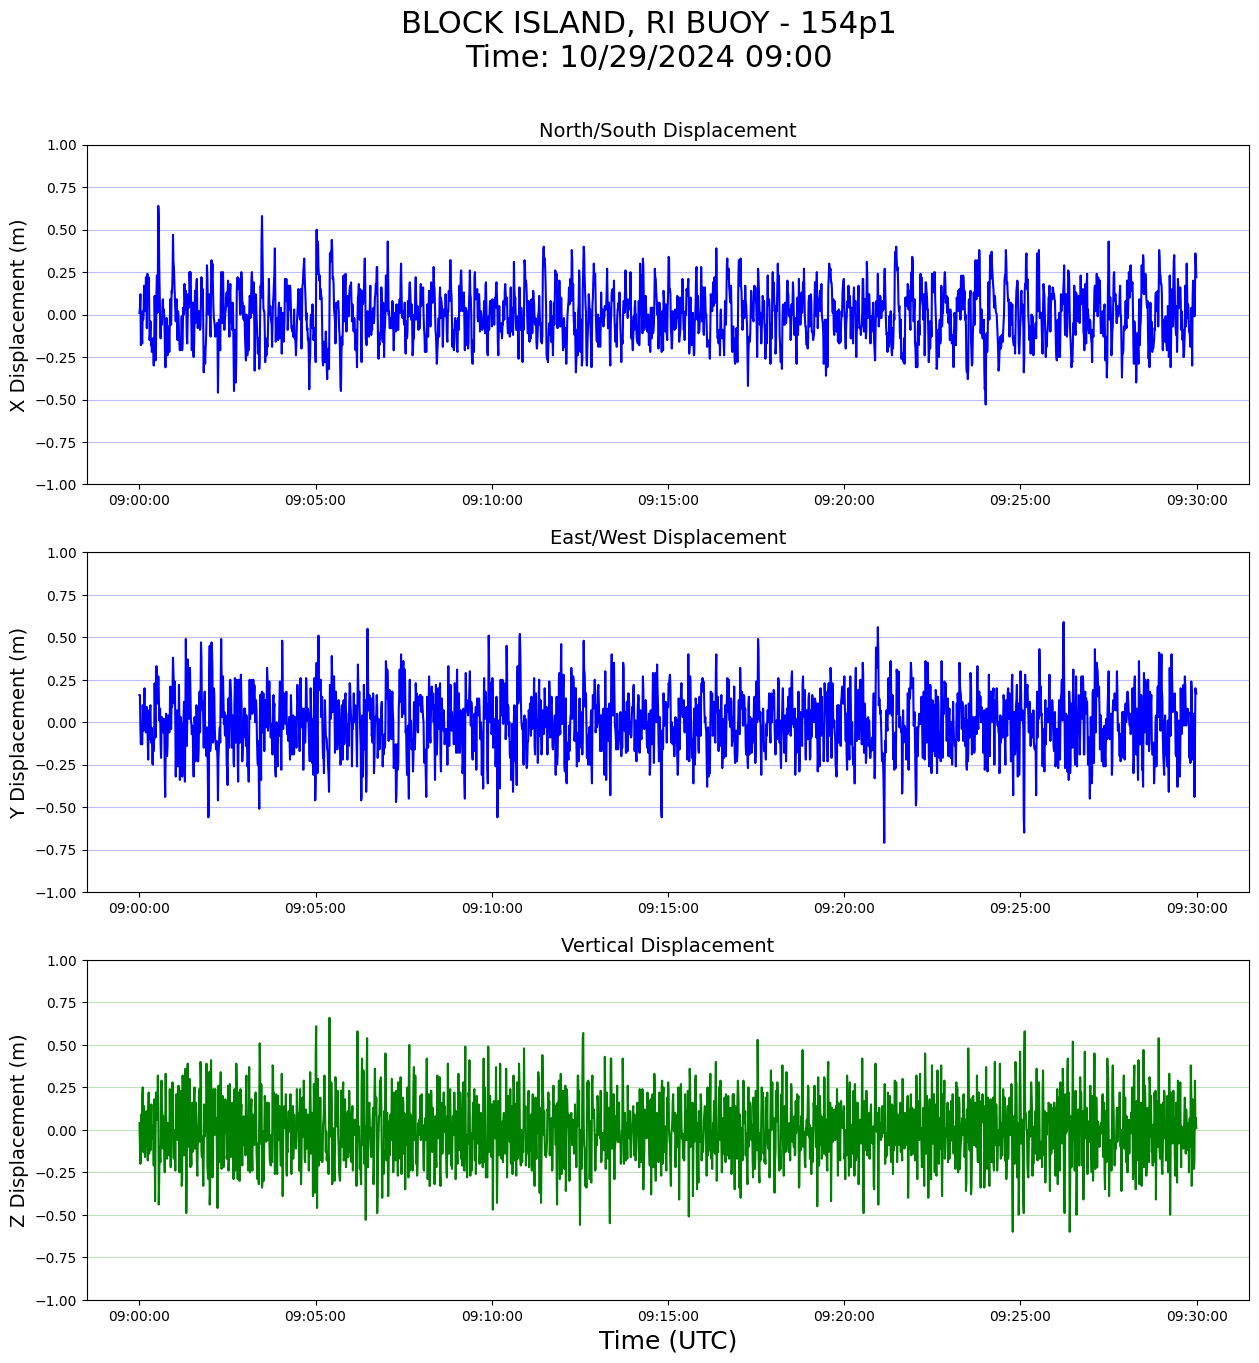

In [10]:
# Specify figure size
fig = plt.figure(figsize=(15,15))

# Limit data to date/times
x = xdisp[start_index:end_index]
y = ydisp[start_index:end_index]
z = zdisp[start_index:end_index]
qc = qc_flag[start_index:end_index]

# Filter out by quality control level
x = np.ma.masked_where(qc>qc_level,x)
y = np.ma.masked_where(qc>qc_level,y)
z = np.ma.masked_where(qc>qc_level,z)

# Create 3 stacked subplots for three Directional Displacement Parameters (xyz)
plt_x = plt.subplot(3,1,1)
plt_x.plot(sample_t_cut_ms,x,'b')
plt_y = plt.subplot(3,1,2, sharex=plt_x)
plt_y.plot(sample_t_cut_ms,y,'b')
plt_z = plt.subplot(3,1,3, sharex=plt_x)
plt_z.plot(sample_t_cut_ms,z,'g')

# Set titles
plt.suptitle(station_title + "\n" + "Time: " + start_date, fontsize=22, y=0.97)

# Set x-axis tick format to "HH:MM:SS" and tick interval to every 5 minutes
#days = mpldts.MinuteLocator(interval=5) 
daysFmt = mpldts.DateFormatter('%H:%M:%S')
#plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(daysFmt)

ymin=np.floor(min(min(x), min(y), min(z)))
ymax=np.ceil(max(max(x), max(y), max(z)))

# Set y-axis limits for each plot
plt_x.set_ylim(ymin,ymax)
plt_y.set_ylim(ymin,ymax)
plt_z.set_ylim(ymin,ymax)

# Label each subplot title
plt_x.set_title('North/South Displacement', fontsize=14)
plt_y.set_title('East/West Displacement', fontsize=14)
plt_z.set_title('Vertical Displacement', fontsize=14,y=1)

# Label each y-axis
plt_x.set_ylabel('X Displacement (m)', fontsize=14)
plt_y.set_ylabel('Y Displacement (m)', fontsize=14)
plt_z.set_ylabel('Z Displacement (m)', fontsize=14)

# Label x-axis
plt.xlabel('Time (UTC)', fontsize=18)

# Plot dashed gridlines
plt_x.grid(axis='y', which='major', color='b', linestyle='-', alpha=0.25)
plt_y.grid(axis='y', which='major', color='b', linestyle='-', alpha=0.25)
plt_z.grid(axis='y', which='major', color='g', linestyle='-', alpha=0.25)